In [29]:
# Imports
from pandas import read_csv 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score

In [30]:
#  Load dataset and create train-test sets
data = read_csv('data/hairdryer.csv')

In [31]:
var_names = data.columns[0:-1]

In [32]:
data = data.to_numpy()

In [33]:
# Run this cell to normalize variables

"""scaler = MinMaxScaler()
data = scaler.fit_transform(data)"""

'scaler = MinMaxScaler()\ndata = scaler.fit_transform(data)'

In [34]:
# train/test split
X = data[:,0:-1]
y = data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
# %% Cluster the input-output space

number_of_clusters = 2

cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=number_of_clusters)  # Number of clusters
clust_centers, part_matrix, _ = cl.cluster(method='fcm')

In [43]:
# %% Estimate membership functions parameters
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

In [44]:
# %% Estimate consequent parameters
ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

In [45]:
# %% Build first-order Takagi-Sugeno model
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=True) #change this setting to save simpful code
model = modbuilder.get_model()

 * Detected 2 rules / clusters
 * Code saved to file Simpful_code.py
 * Detected Sugeno model type


In [46]:
# %% Get model predictions
modtester = SugenoFISTester(model, X_test, var_names)
y_pred = modtester.predict()[0]

In [47]:
# %% Compute regression metrics
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.3f}".format(mse))
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error: {:.1f}%".format(mape*100))
exp_var = explained_variance_score(y_test, y_pred)
print("Explained Variance Score: {:.3f}".format(exp_var))

Mean Squared Error: 0.726
Mean Absolute Percentage Error: 15.3%
Explained Variance Score: 0.001


fazer gráfico com actual vs predicted values

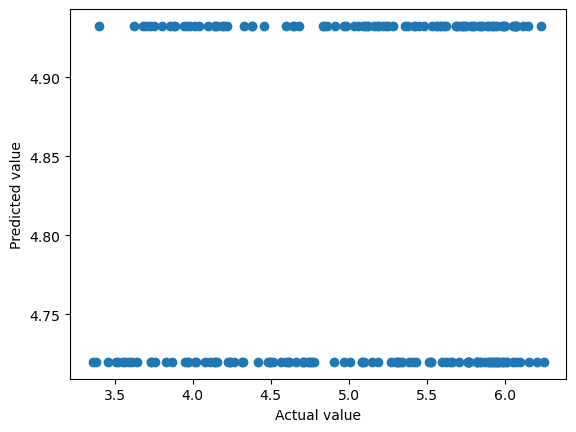

In [48]:
### Plot the actual values vs the predicted values of the test data using the matplotlib library

# this is done already on the cell above 
""""# Predict the labels of the test data
pred = model.predict_test_data()"""


"""# Get the actual labels of the test data
_, actual = modbuilder.get_data(data_set='test')
"""

# Create scatterplot
import matplotlib.pyplot as plt 
plt.scatter(y_test, y_pred)
plt.xlabel('Actual value') 
plt.ylabel('Predicted value')
#plt.plot([0,85],[0,85],'r')     # Add a reference line
plt.show()

usar K-fold CV para obter performance de cada modelo (modelos com diferentes numeros de clusters)